# 1. IMPORT PACKAGES

In [1]:
# To check if GPU is active
from tensorflow.python.client import device_lib

# Load Data
import os
import cv2 #opencv-latest version
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Model Training
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split

# Model Evaluation
from tensorflow.math import confusion_matrix

### Check GPU

In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16355201803284348065
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 6535731942767309925
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]Metal device set to: Apple M1



2023-05-09 14:40:55.299116: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-09 14:40:55.299204: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 2. LOAD DATA

The ASL Dataset contains 29 classes of images, including all the alphabets, delete, space and nothing. The data is divided into two folders for test and training purposes.

### Data Directories

In [3]:
train_dir = 'Data/asl_alphabet_train'
test_dir = 'Data/asl_alphabet_test'

### Convert data from folder to Array of images/X and labels/y

Since we are reading and storing 87,000 images, this step would require some time to finish.

In [4]:
def get_data(data_dir:str,image_size:int=32)->"Dataset":
    images = []
    labels = []
    mapping = {}
    
    dir_list = os.listdir(data_dir) #Move to Data directory
    dir_list.sort()
    for i in range(len(dir_list)):  #loop over each sub-folder in Directory
        print("Obtaining images of", dir_list[i], "...")
        mapping[i]=dir_list[i]      #Map character labels to Integers
        
        for image in os.listdir(data_dir + "/" + dir_list[i]):            
            img = cv2.imread(data_dir + '/' + dir_list[i] + '/' + image)  #read image in folder
            img = cv2.resize(img, (image_size,image_size))                #resize image
            images.append(img)
            labels.append(i)
    
    return images, labels, mapping
        
X, y, Label_mapping  = get_data(train_dir)

Obtaining images of A ...
Obtaining images of B ...
Obtaining images of C ...
Obtaining images of D ...
Obtaining images of E ...
Obtaining images of F ...
Obtaining images of G ...
Obtaining images of H ...
Obtaining images of I ...
Obtaining images of J ...
Obtaining images of K ...
Obtaining images of L ...
Obtaining images of M ...
Obtaining images of N ...
Obtaining images of O ...
Obtaining images of P ...
Obtaining images of Q ...
Obtaining images of R ...
Obtaining images of S ...
Obtaining images of T ...
Obtaining images of U ...
Obtaining images of V ...
Obtaining images of W ...
Obtaining images of X ...
Obtaining images of Y ...
Obtaining images of Z ...
Obtaining images of del ...
Obtaining images of nothing ...
Obtaining images of space ...


In [5]:
print(len(X), len(y))

87000 87000


### Mapping
Convert Labels(string) to integers, because Cnn can only train on numbers.Will also be used to convert the models predicted output back to its appropraite labels.

In [6]:
print("Label Mapping:",Label_mapping)

Label Mapping: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}


# 3. Data Visualization

Let us load one sample image from each class.

Function to plot images

In [7]:
def plot_sample_images(fig_size:tuple=(16,5)):
    classes =  list(Label_mapping.values()) #Characters in mapping as list
    figure = plt.figure()                   # Create a new figure object    
    plt.figure(figsize=fig_size)            # Set the figure size

    # Iterate over the range of images
    for i in range (0,29):
        plt.subplot(3,10,i+1)# Create a subplot within the figure grid
        # Remove x-axis and y-axis ticks
        plt.xticks([])
        plt.yticks([])
        path = train_dir + f"/{classes[i]}/{classes[i]}1.jpg" # Construct the path to the image file
        img = plt.imread(path)# Read the image file
        plt.imshow(img)# Display the image in the subplot
        plt.xlabel(classes[i])# Set the label of the subplot as the corresponding class

<Figure size 640x480 with 0 Axes>

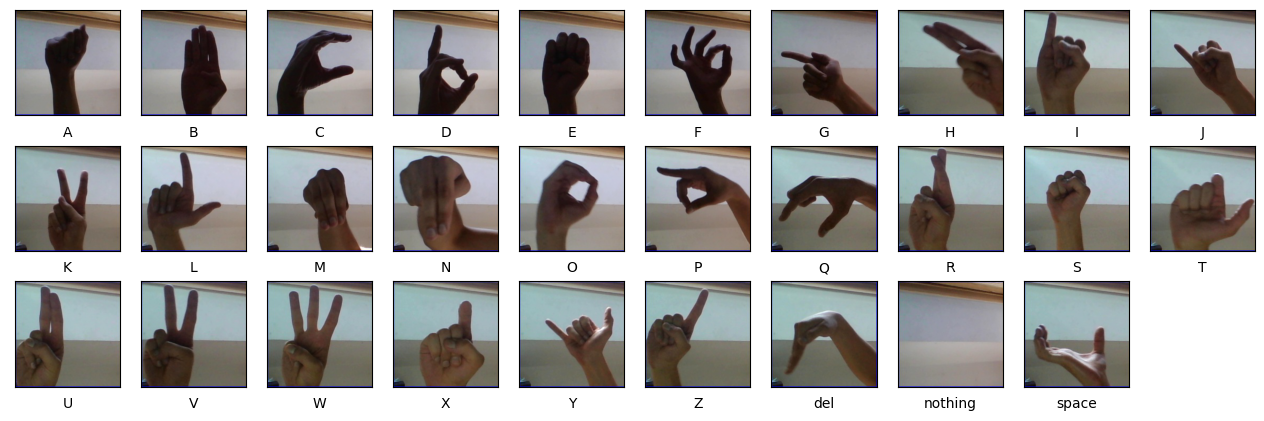

In [8]:
plot_sample_images()

# 4. Data PreProcessing

1. Convert images to Numpy Arrays and Normalize them.
2. Split into Train/Test.

In [9]:
def preprocess_data(X:'Image Array', y:'Image Array')-> 'Dataset':
    np_X = np.array(X)                          #Convert to numpy array
    normalised_X = np_X.astype('float32')/255.0 #normalize numpy array
    
    label_encoded_y = utils.to_categorical(y)   #makes processing faster 
    x_train, x_test, y_train, y_test = train_test_split(normalised_X, label_encoded_y, test_size = 0.1) #train/test spliy
    
    return x_train, x_test, y_train, y_test

In [10]:
x_train, x_test, y_train, y_test = preprocess_data(X,y)

In [11]:
print("Training data:", x_train.shape)
print("Test data:", x_test.shape)

Training data: (78300, 32, 32, 3)
Test data: (8700, 32, 32, 3)


# 5. Define CNN model

### Define Hyperparameters

In [12]:
#Number of possible outputs -> 26letters + space + delete + nothing
classes = 29
#Train Loader batch size
batch = 32
#Number of times CNN is run
epochs = 15
#Starting Learning rate
learning_rate = 0.001

### Function to build model

The defined model is a 4 layer deep CNN model. Batch normalisation and dropout layers have been added to avoid overfitting on the training set and perform regularization. Max pooling is also applied.

The three CNN layers have been flattened out and connected to a dense layer before performing classification using the softmax activation function.

<img src='Main/Images/generic_Cnn.png' />

```padding='same'``` = with zero padding 

```model.add(Conv2D(...))``` = adds a Conolutional Layer 

```model.add(MaxPooling2D``` = adds a Max Pooling Layer

```model.add(BatchNormalization())``` = Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

```model.add(Dropout(0.2))``` = The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.

```model.add(Flatten())``` = Convert N-D data into a 1-D data

In [13]:
def Build_model(Conv_size:tuple=(3,3),MaxPool_size:tuple=(2,2)):
    model = Sequential()

    #Feature Extraction 
    model.add(Conv2D(64, Conv_size, padding='same', input_shape=(32, 32,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=MaxPool_size))
    model.add(BatchNormalization())

    model.add(Conv2D(128, Conv_size, padding='same', input_shape=(32, 32,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=MaxPool_size))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(256, Conv_size, padding='same', input_shape=(32, 32,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=MaxPool_size))
    model.add(BatchNormalization())
    
    #Classification
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(classes, activation='softmax')) 
    
    return model

In [14]:
model = Build_model()

2023-05-09 14:41:17.640824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-09 14:41:17.640846: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Adam optimizer

The Adam optimizer is an algorithm used in machine learning to optimize the training of neural networks.It helps accelerate the convergence of the model during training by adjusting the learning rate dynamically for each parameter.

In [15]:
adam = Adam(learning_rate = learning_rate)

### Compile model

```loss='categorical_crossentropy'``` = Computes the crossentropy loss between the labels and predictions.Use this crossentropy loss function when there are two or more label classes. 

```metrics=['accuracy']``` = Calculates how often predictions equal labels.

In [16]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

### Model Summary

Summary of layers in CNN model. Overall it contains 4,596,765 trainable parameters.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                        

# 6. Train Model

Trained model using standard 80:20  train:validate split. This will take some time as the Dataset is very large.

In [18]:
history = model.fit(x_train, y_train, batch_size=batch, epochs=epochs,validation_split=0.2,
                    shuffle = True, verbose=1)

Epoch 1/15


2023-05-09 14:41:18.073988: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-09 14:41:18.375791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1958/1958 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.8240

2023-05-09 14:41:58.547768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1958/1958 [==============================] - 44s 22ms/step - loss: 0.5890 - accuracy: 0.8240 - val_loss: 0.2157 - val_accuracy: 0.9264
Epoch 2/15
1958/1958 [==============================] - 43s 22ms/step - loss: 0.1167 - accuracy: 0.9643 - val_loss: 0.5039 - val_accuracy: 0.8877
Epoch 3/15
1958/1958 [==============================] - 42s 21ms/step - loss: 0.0909 - accuracy: 0.9748 - val_loss: 0.3813 - val_accuracy: 0.9250
Epoch 4/15
1958/1958 [==============================] - 44s 22ms/step - loss: 0.0726 - accuracy: 0.9813 - val_loss: 0.7334 - val_accuracy: 0.8480
Epoch 5/15
1958/1958 [==============================] - 44s 22ms/step - loss: 0.0587 - accuracy: 0.9854 - val_loss: 1.4480 - val_accuracy: 0.8162
Epoch 6/15
1958/1958 [==============================] - 44s 22ms/step - loss: 0.0480 - accuracy: 0.9875 - val_loss: 0.3689 - val_accuracy: 0.9172
Epoch 7/15
1958/1958 [==============================] - 42s 22ms/step - loss: 0.0491 - accuracy: 0.9885 - val_loss: 0.2184 - val_accura

# 7. Evaluate Model

It reports 0.99885 Test accuracy which is very commendable.

In [19]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

272/272 [==============================] - 2s 8ms/step - loss: 0.1727 - accuracy: 0.9734
Test accuracy: 0.9734482765197754
Test loss: 0.17268989980220795


Function to plot model result

In [20]:
def plot_results(model):
    plt.figure(figsize=(12, 12))
    #Plot train,validate accuracy
    plt.subplot(3, 2, 1)
    plt.plot(history.history['accuracy'], label = 'train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    #Plot train,validate loss
    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    #Plot confusion matrix
    print("\nConfusion Matrix\n")
    y_hat = model.predict(x_test,verbose=1) #predict x_test
    #convert predictions and y_test into 1D arrays of classes
    y_hat1 = np.argmax(y_hat,axis=1)    
    y_test1 = np.argmax(y_test,axis=1)
    matrix = confusion_matrix(y_test1,y_hat1,num_classes=29) #calculate confusion matrix
    classes =  list(Label_mapping.values())                  #list of possible classes
    matrix_df = pd.DataFrame(matrix, index = [i for i in classes],columns = [i for i in classes]) #convert matrix to DataFrame
    plt.figure(figsize=(12,10))
    sns.heatmap(matrix_df, annot=True,) #plot DataFrame using seaborn

As you can observe, the training and validation loss decreases with epochs while the training and validation accuracy increases. Our training and validation metrics continue to be relative, indicating that the model is generalised and not overfitting.

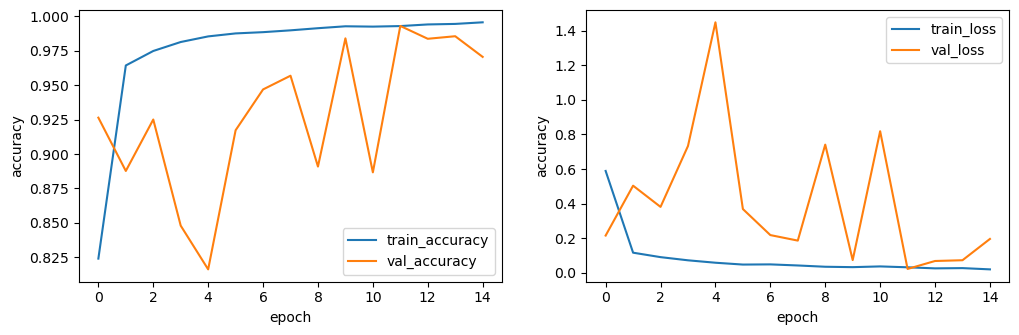


Confusion Matrix

 30/272 [==>...........................] - ETA: 1s

2023-05-09 14:52:12.096966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


272/272 [==============================] - 2s 7ms/step


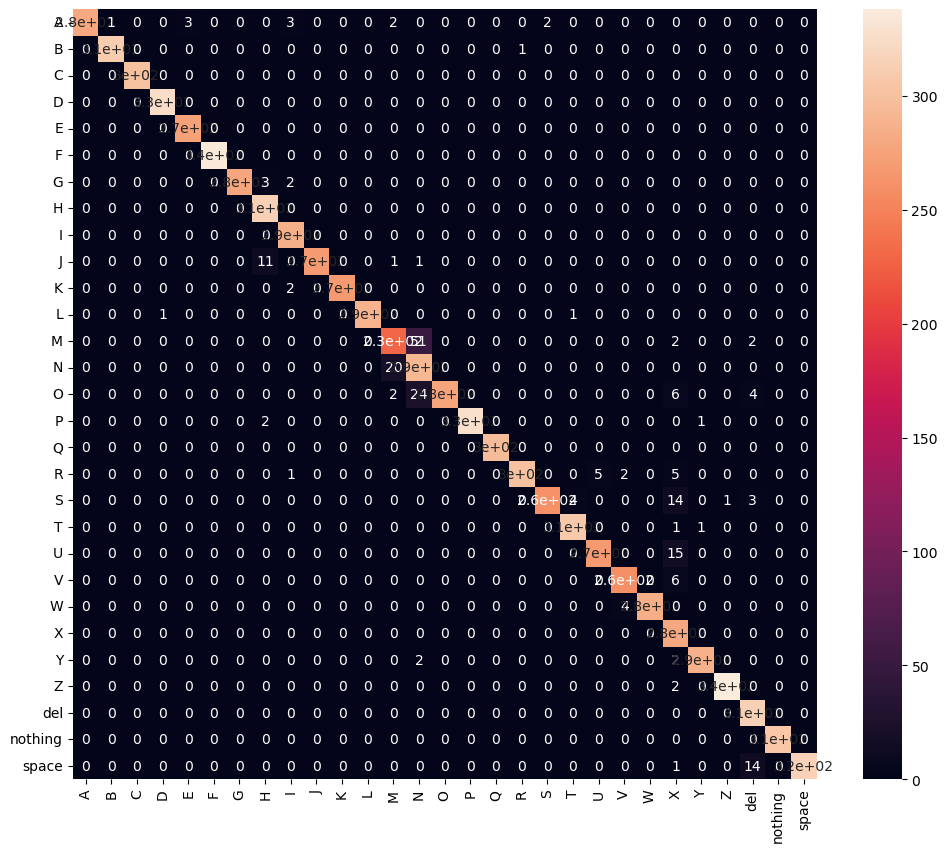

In [21]:
plot_results(model)

# 8. Save Model

There are two formats you can use to save an entire model to disk: the **TensorFlow SavedModel format**, and the older **Keras H5 format**.

### SavedModel
is the more comprehensive save format that saves the model architecture, weights, and the traced Tensorflow subgraphs of the call functions. This enables Keras to restore both built-in layers as well as custom objects.

In [22]:
model.save("Saved_models/Model_sm")

INFO:tensorflow:Assets written to: Saved_models/Model_sm/assets


INFO:tensorflow:Assets written to: Saved_models/Model_sm/assets


### HDF5
saves a single file containing the model's architecture, weights values, and compile() information. It is a light-weight alternative to SavedModel.

In [23]:
model.save("Saved_models/Model_hdf5",save_format='h5')

### TensorFlow Lite 

TensorFlow Lite is a mobile library for deploying models on mobile, microcontrollers and other edge devices.

In [24]:
import tensorflow as tf

In [25]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("Saved_models/Model_sm") # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT] #optimize model for faster performance
tflite_model = converter.convert()

# Save the model.
with open('Saved_models/Model_tflite.tflite', 'wb') as f:
  f.write(tflite_model)

2023-05-09 14:52:17.566084: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-05-09 14:52:17.566103: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-05-09 14:52:17.566521: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: Saved_models/Model_sm
2023-05-09 14:52:17.568551: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-09 14:52:17.568557: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: Saved_models/Model_sm
2023-05-09 14:52:17.572062: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-05-09 14:52:17.573071: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-05-09 14:52:17.668548: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: Saved_models/M